#Given a budget of 30 million dollar (or less) and genre, can I predict gross domestic profit using linear regression?

In [1]:
%matplotlib inline
import pickle
from pprint import pprint
import pandas as pd
import numpy as np
from dateutil.parser import parse
import math
# For plotting
import seaborn as sb
import matplotlib.pyplot as plt

# For linear regression
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation

In [2]:
def perform_linear_regression(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params



    #Plotting
    axes.plot(X_train[columns], y_train, 'go')
    #axes.plot(X_test[columns], y_test, 'yo')
    #axes.plot(X_test[columns], fitted.predict(X_test), 'ro')
    axes.plot(X[columns], fitted.predict(X), '-')
    
    axes.set_title('{0} (Rsquared = {1:.2f})  p = {2:.2f} m = {3:.2f}'.format(title, r_squared, pval[1], np.exp(params[1])))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    axes.set_ylim(0, 25)
    return None



In [3]:
def perform_linear_regression1(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params
    y_test = y_test
    #Plotting
    #axes.plot(X_train[columns], y_train, 'go')
    axes.plot(X_test[columns], y_test, 'yo')
    #axes.plot(X_test[columns], fitted.predict(X_test), 'ro')
    
    
    axes.plot(X[columns], fitted.predict(X), '-')
    
    axes.set_title('{0} (Rsquared = {1:.2f}) p = {2:.2f}'.format(title, r_squared, pval[1]))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    axes.set_ylim(0, 25)
    return None



In [4]:
def perform_linear_regression_all(df, axes, title):
    plot_data = df.sort('budget', ascending = True)
    

    y, X = dmatrices('log_gross ~ budget', data = plot_data, return_type = 'dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    
    columns = ['budget']
    #Patsy
    model = sm.OLS(y_train,X_train)
    fitted = model.fit()
    r_squared =  fitted.rsquared
    pval = fitted.pvalues
    params = fitted.params
    
    #Plotting
    axes.plot(X_train[columns], y_train, 'go')
    axes.plot(X_test[columns], y_test, 'yo')
    
    axes.set_title('{0}'.format(title))
    axes.set_xlabel('Budget')
    axes.set_ylabel('ln(Gross)')
    axes.set_ylim(0, 25)
    return None



In [5]:
def create_genre_column(df, genre):
    return df['genre'].apply(lambda x: 1 if genre in x else 0)

In [6]:
def get_genre_dataframes(df, genre):
    columns = ['log_gross', 'gross', 'log_budget', 'budget', 'runtime']
    df_out = df.copy()[df[genre] == 1][columns]
    df_out['genre'] = genre
    return df_out

###Load the movie dictionary

In [7]:
d = pickle.load(open('movie_dictionary.p'))

In [15]:
#Create a dataframe 
df = pd.DataFrame.from_dict(d, orient = 'index')


###Clean the data and remove N/A's
Keep only movies with a positive runtime

In [16]:
df2 = df.copy()
df2 = df2[['gross', 'date', 'budget', 'genre', 'runtime']]
df2['gross'][df2.gross == 'N/A'] = np.nan
df2['budget'][df2.budget == 'N/A'] = np.nan
df2['date'][df2.date == 'N/A'] = np.nan
df2['genre'][df2.genre == 'N/A'] = np.nan
df2['genre'][df2.genre == 'Unknown'] = np.nan
df2['runtime'][df2.runtime == 'N/A'] = np.nan
df2 = df2[df2.date > parse('01-01-2005').date()]
df2 = df2[df2.runtime >= 0]
#df2 = df2[df2.budget <30]
df2 = df2.dropna()

For budget and gross, if data is missing, populate them with the mean of all the movies

In [17]:
#df2['budget'][df2['budget'].isnull()] = df2['budget'].mean()
#df2['gross'][df2['gross'].isnull()] = df2['gross'].mean()
df2['date'] = pd.to_datetime(df2['date'])
df2['year'] = df2['date'].apply(lambda x: x.year)
df2['gross'] = df2['gross'].astype(float)
df2['budget'] = df2['budget'].astype(float)
df2['runtime'] = df2['runtime'].astype(float)
df2['genre'] = df2['genre'].astype(str)


###Create some log columns

In [18]:
df2['log_runtime'] = df2['runtime'].apply(lambda x: np.log(x))
df2['log_budget'] = df2['budget'].apply(lambda x: np.log(x))
df2['log_gross'] = df2['gross'].apply(lambda x: np.log(x))

###How does the gross and budget data look? (Not normally distributed)

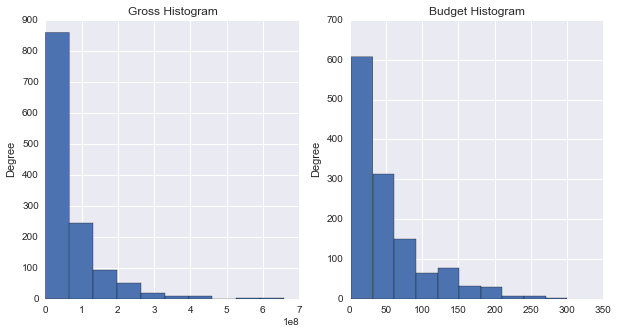

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
df2['gross'].plot(ax = axes[0], kind = 'hist', title = 'Gross Histogram')
df2['budget'].plot(ax = axes[1], kind = 'hist', title = 'Budget Histogram')

###Looks more normally distributed now!

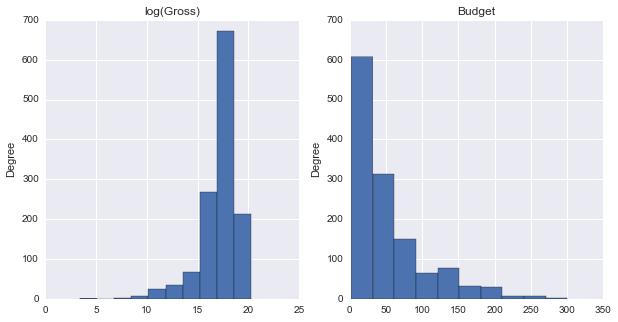

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
df2['log_gross'].plot(ax = axes[0], kind = 'hist', title = 'log(Gross)')
df2['budget'].plot(ax = axes[1], kind = 'hist', title = 'Budget')

###Check top grossing genres

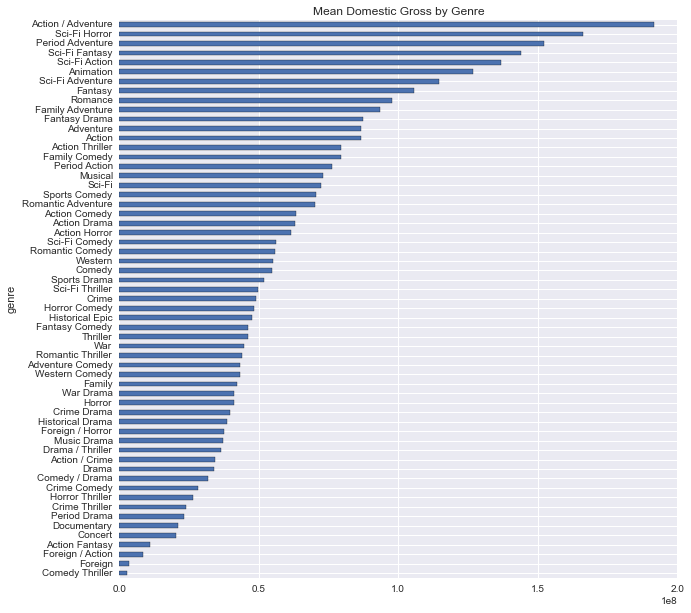

In [21]:
df2.groupby('genre')[['gross']].mean().sort('gross', ascending = True).plot(figsize = (10,10), kind = 'barh', legend = False, title = 'Mean Domestic Gross by Genre')

In [22]:
test = df2.groupby('genre')[['gross']].mean()
test['Count'] = df2.groupby('genre')[['gross']].count()
test.sort('gross', ascending = False)

,gross,Count
genre,,
Action / Adventure,1.916059e+08,48
Sci-Fi Horror,1.661205e+08,10
Period Adventure,1.523553e+08,13
Sci-Fi Fantasy,1.441466e+08,3
Sci-Fi Action,1.368970e+08,27
Animation,1.268238e+08,95
Sci-Fi Adventure,1.146869e+08,8
Fantasy,1.057530e+08,28
Romance,9.778838e+07,28


### Check top genres by count

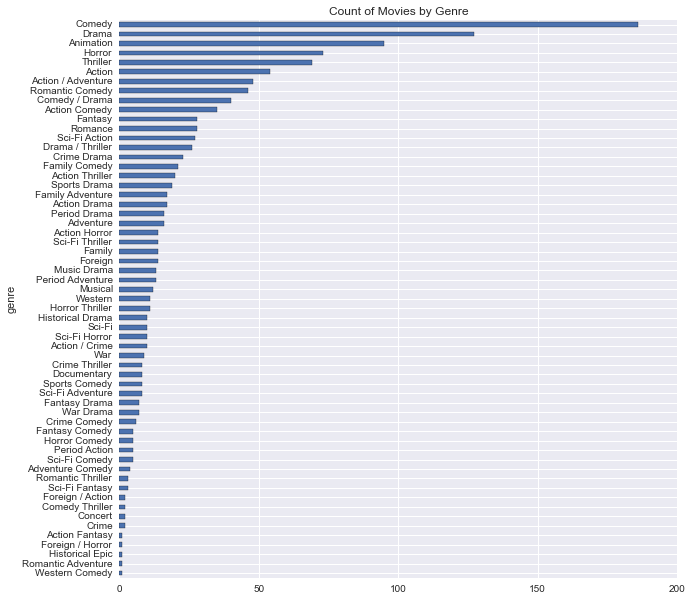

In [23]:
df2.groupby('genre')[['gross']].count().sort('gross', ascending = True).plot(figsize = (10,10), kind = 'barh', legend = False, title = 'Count of Movies by Genre')

###Create categories for top unique grossing genres

In [24]:
genre_list = ['Comedy', 'Drama', 'Horror', 'Romance', 'Thriller', 'Sci-Fi', 'Music', 'Action', 'Adventure', 'Historical', \
             'Family', 'War', 'Sports', 'Crime', 'Animation']
  
for genre in genre_list:
    df2[genre] = create_genre_column(df2, genre)


###Create a new column for genres that concatenates all the individual columns

In [25]:
df_comedy = get_genre_dataframes(df2, 'Comedy')
df_drama = get_genre_dataframes(df2, 'Drama')
df_horror = get_genre_dataframes(df2, 'Horror')
df_romance = get_genre_dataframes(df2, 'Romance')
df_thriller = get_genre_dataframes(df2, 'Thriller')
df_scifi = get_genre_dataframes(df2, 'Sci-Fi')
df_music = get_genre_dataframes(df2, 'Music')
df_action = get_genre_dataframes(df2, 'Action')
df_adventure = get_genre_dataframes(df2, 'Adventure')
df_historical = get_genre_dataframes(df2, 'Historical')
df_family = get_genre_dataframes(df2, 'Family')
df_war = get_genre_dataframes(df2, 'War')
df_sports = get_genre_dataframes(df2, 'Sports')
df_crime = get_genre_dataframes(df2, 'Crime')
df_animation = get_genre_dataframes(df2, 'Animation')

In [26]:
final_df = df_comedy.copy()
final_df = final_df.append(df_drama)
final_df = final_df.append(df_horror)
final_df = final_df.append(df_romance)
final_df = final_df.append(df_thriller)
final_df = final_df.append(df_scifi)
final_df = final_df.append(df_music)
final_df = final_df.append(df_action)
final_df = final_df.append(df_adventure)
final_df = final_df.append(df_historical)
final_df = final_df.append(df_family)
final_df = final_df.append(df_war)
final_df = final_df.append(df_sports)
final_df = final_df.append(df_crime)
final_df = final_df.append(df_animation)
final_df[['genre', 'budget', 'log_gross']].head()


,genre,budget,log_gross
2 Guns (2013),Comedy,61,18.141132
21 Jump Street (2012),Comedy,42,18.746003
21 and Over (2013),Comedy,13,17.061316
22 Jump Street (2014),Comedy,50,19.071543
27 Dresses (2008),Comedy,30,18.156828


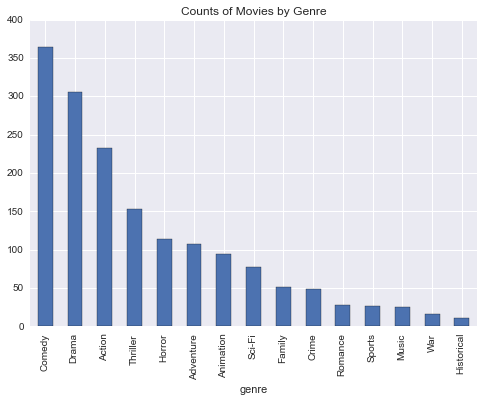

In [27]:
final_df[['log_gross', 'genre']].groupby('genre').count().sort('log_gross', ascending = False).plot(kind = 'bar', legend = False, title = 'Counts of Movies by Genre')

In [28]:
temp = final_df[['gross', 'genre']].groupby('genre').mean()
temp['Count'] = final_df[['gross', 'genre']].groupby('genre').count()
temp.sort('gross',ascending = False)
temp = temp.rename(columns={'gross': 'Average Gross'})
temp.sort('Average Gross', ascending = False)

,Average Gross,Count
genre,,
Adventure,1.431509e+08,107
Animation,1.268238e+08,95
Sci-Fi,1.092132e+08,77
Action,1.032417e+08,233
Romance,9.778838e+07,28
Family,7.398361e+07,52
Sports,5.741310e+07,27
Music,5.436875e+07,25
Comedy,5.382479e+07,364


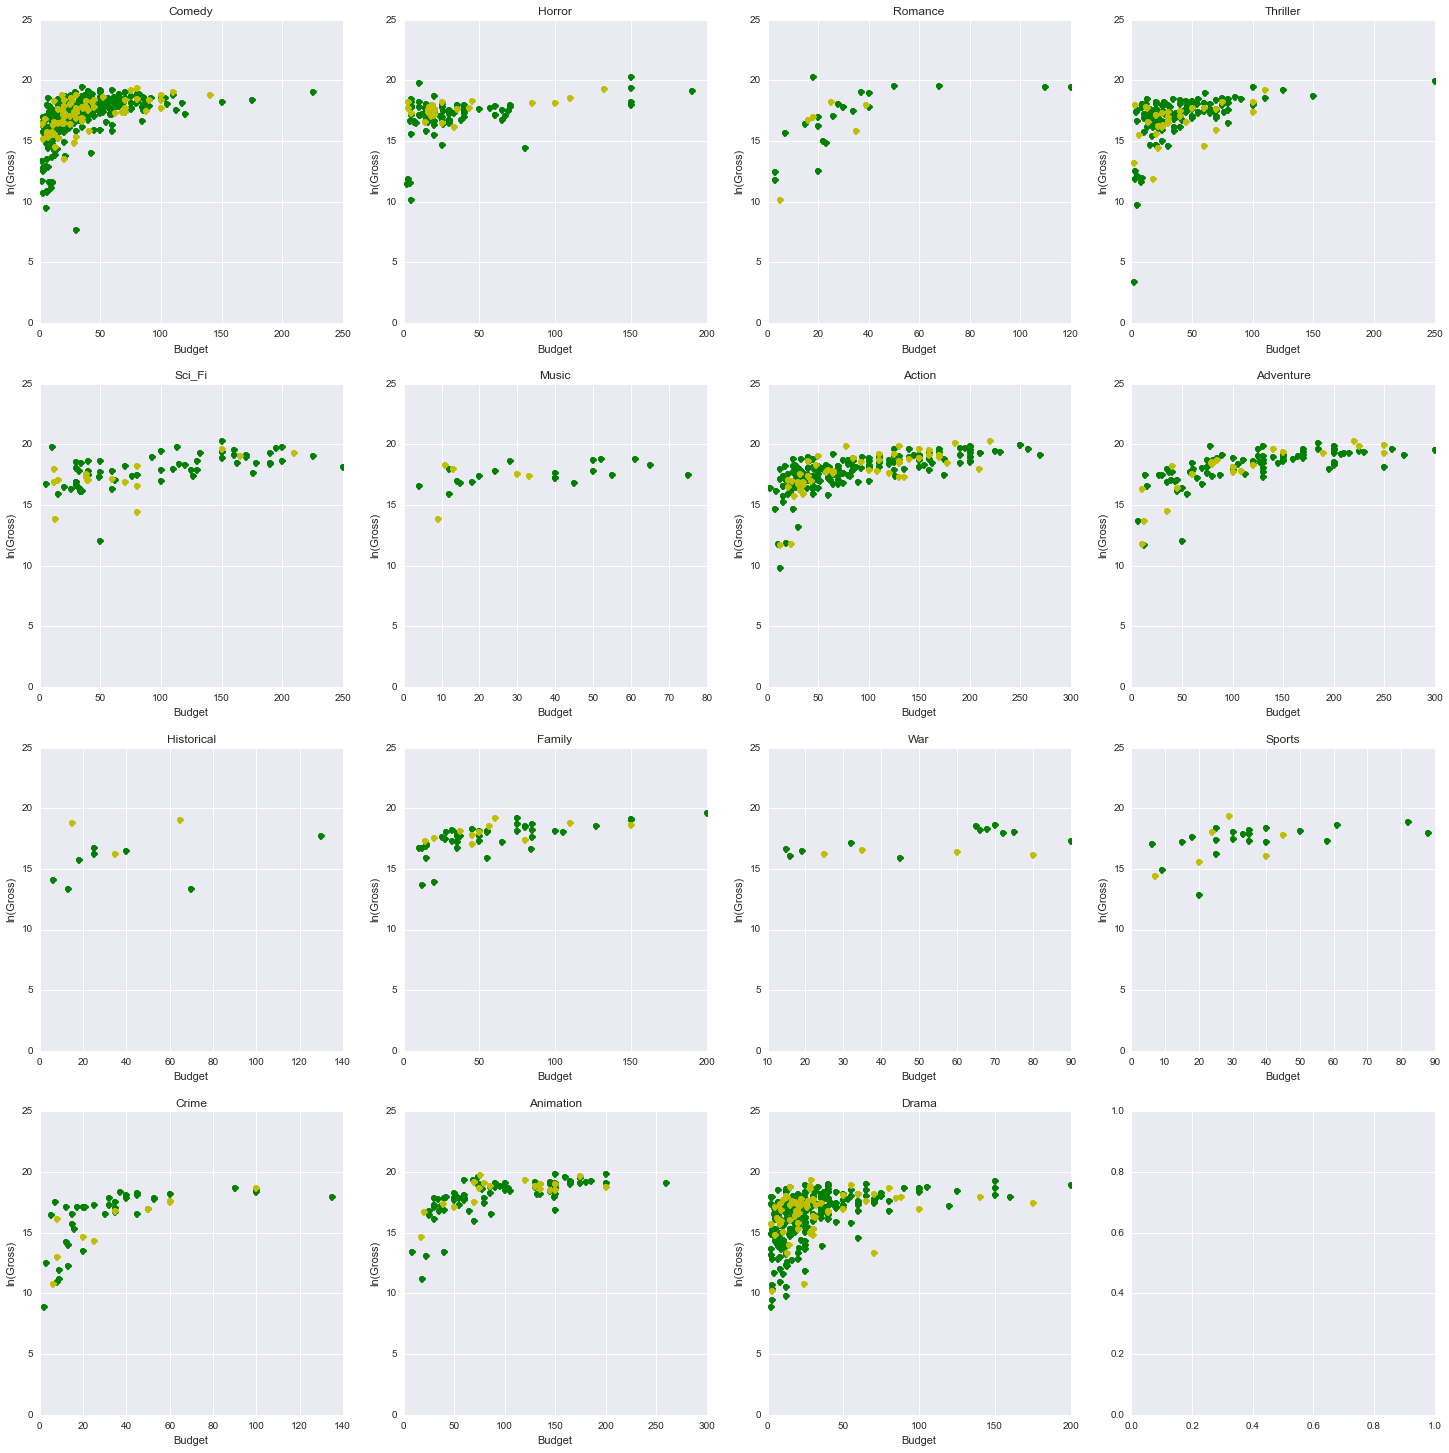

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression_all(df_comedy, axes[0,0], 'Comedy')
perform_linear_regression_all(df_horror, axes[0,1], 'Horror')
perform_linear_regression_all(df_romance, axes[0,2], 'Romance')
perform_linear_regression_all(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression_all(df_scifi, axes[1,0], 'Sci_Fi')
perform_linear_regression_all(df_music, axes[1,1], 'Music')
perform_linear_regression_all(df_action, axes[1,2], 'Action')
perform_linear_regression_all(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression_all(df_historical, axes[2,0], 'Historical')
perform_linear_regression_all(df_family, axes[2,1], 'Family')
perform_linear_regression_all(df_war, axes[2,2], 'War')
perform_linear_regression_all(df_sports, axes[2,3], 'Sports')
perform_linear_regression_all(df_crime, axes[3,0], 'Crime')
perform_linear_regression_all(df_animation, axes[3,1], 'Animation')
perform_linear_regression_all(df_drama, axes[3,2], 'Drama')



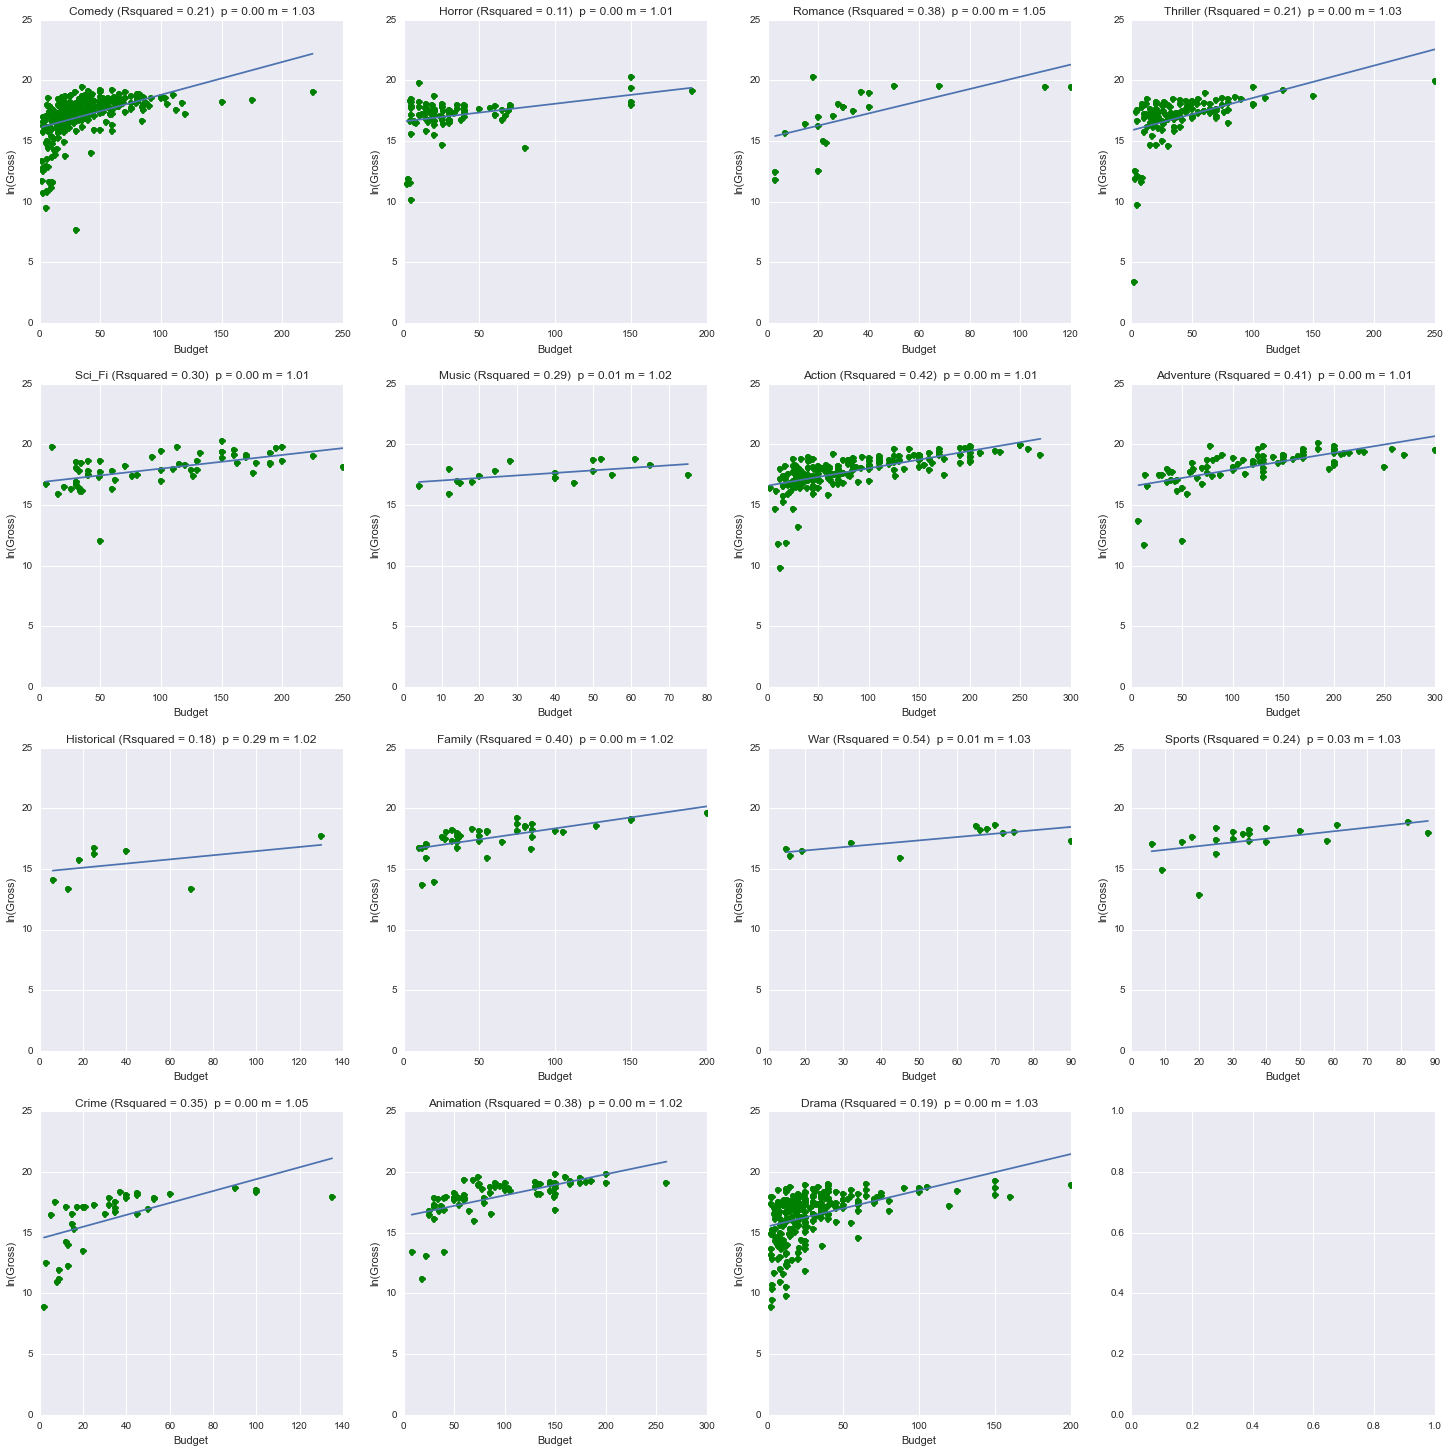

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression(df_comedy, axes[0,0], 'Comedy')
perform_linear_regression(df_horror, axes[0,1], 'Horror')
perform_linear_regression(df_romance, axes[0,2], 'Romance')
perform_linear_regression(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression(df_scifi, axes[1,0], 'Sci_Fi')
perform_linear_regression(df_music, axes[1,1], 'Music')
perform_linear_regression(df_action, axes[1,2], 'Action')
perform_linear_regression(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression(df_historical, axes[2,0], 'Historical')
perform_linear_regression(df_family, axes[2,1], 'Family')
perform_linear_regression(df_war, axes[2,2], 'War')
perform_linear_regression(df_sports, axes[2,3], 'Sports')
perform_linear_regression(df_crime, axes[3,0], 'Crime')
perform_linear_regression(df_animation, axes[3,1], 'Animation')
perform_linear_regression(df_drama, axes[3,2], 'Drama')


###Linear Regression

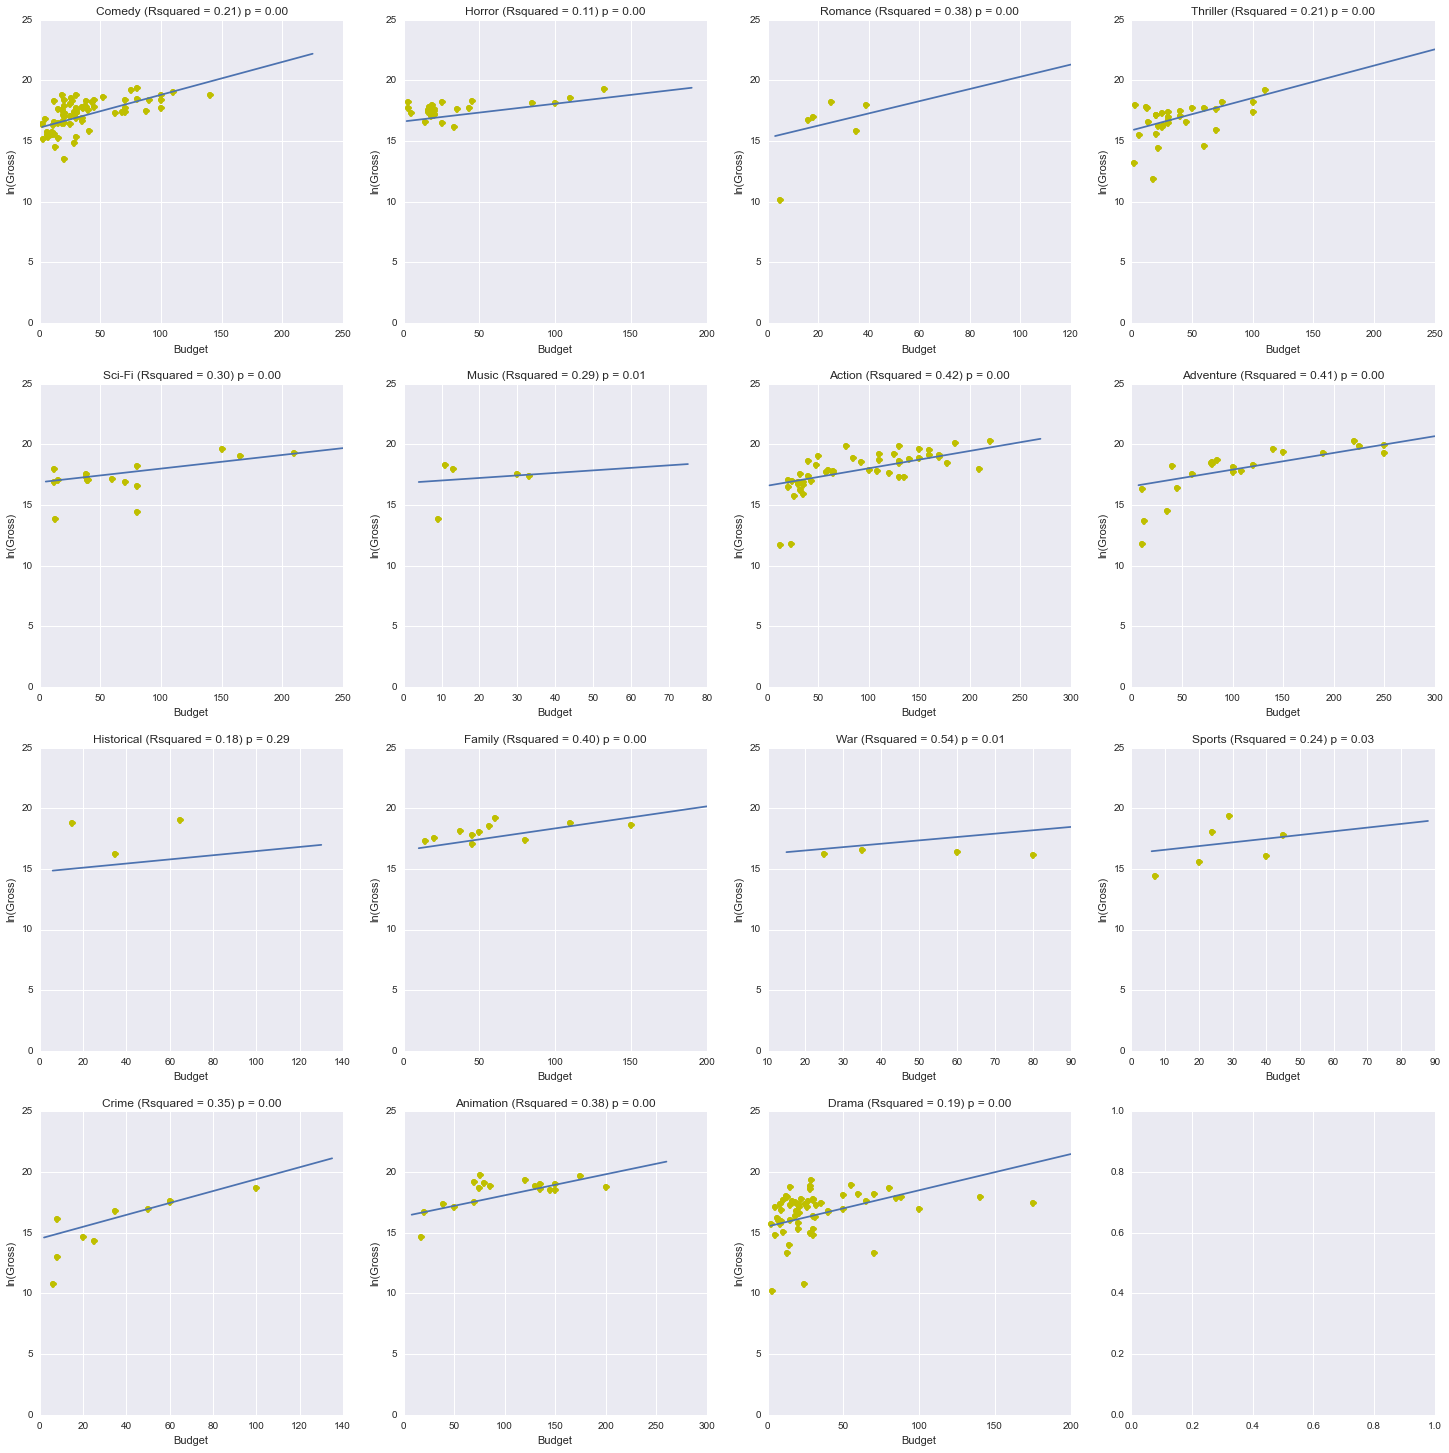

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(25,25))
perform_linear_regression1(df_comedy, axes[0,0], 'Comedy')
perform_linear_regression1(df_horror, axes[0,1], 'Horror')
perform_linear_regression1(df_romance, axes[0,2], 'Romance')
perform_linear_regression1(df_thriller, axes[0,3], 'Thriller')
perform_linear_regression1(df_scifi, axes[1,0], 'Sci-Fi')
perform_linear_regression1(df_music, axes[1,1], 'Music')
perform_linear_regression1(df_action, axes[1,2], 'Action')
perform_linear_regression1(df_adventure, axes[1,3], 'Adventure')
perform_linear_regression1(df_historical, axes[2,0], 'Historical')
perform_linear_regression1(df_family, axes[2,1], 'Family')
perform_linear_regression1(df_war, axes[2,2], 'War')
perform_linear_regression1(df_sports, axes[2,3], 'Sports')
perform_linear_regression1(df_crime, axes[3,0], 'Crime')
perform_linear_regression1(df_animation, axes[3,1], 'Animation')
perform_linear_regression1(df_drama, axes[3,2], 'Drama')

